# Baseline model testing

In [1]:
import sys
# sys.path.append('G:/My Drive/Research/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm/code')
import model.model as mod_code
import plot.single as plt_single
import imp
import importlib
import copy
import numpy as np
import pandas as pd
import pickle
imp.reload(mod_code)
import matplotlib.pyplot as plt
import model.base_inputs as base_inputs
import experiments.POM as POM
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

# 1. imposed decision-making

In [2]:
imp.reload(mod_code)
imp.reload(base_inputs)
inputs = base_inputs.compile()

inputs['model']['T'] = 100
inputs['model']['n_agents'] = 100
inputs['model']['seed'] = 0
inputs['decisions']['framework'] = 'imposed'

inputs['agents']['land_area_init'] = [2]
inputs['market']['fertilizer_cost'] = 40
inputs['adaptation']['conservation']['organic_N_added'] = 40
inputs['adaptation']['fertilizer']['application_rate'] = 80
inputs['adaptation']['conservation']['area_req'] = 0.3
inputs['livestock']['frac_N_import'] = 0
# inputs['land']['organic_N_min_init'] = 500

scenarios = {
    'baseline' : {'decisions' : {'imposed_action' : {'conservation':False,'fertilizer':False}}},
    'fertilizer' : {'decisions' : {'imposed_action' : {'conservation':False,'fertilizer':True}}},
    'conservation' : {'decisions' : {'imposed_action' : {'conservation':True,'fertilizer':False}}},
}
cols = {'baseline' : 'k', 'fertilizer' : 'r', 'conservation' : 'b'}

In [3]:
#### RUN THE MODEL ####
mods = {}
for name, vals in scenarios.items():
    # change the params
    params = copy.deepcopy(inputs)
    for k, v in vals.items():
        for k2, v2 in v.items():
            params[k][k2] = v2
    # initialize and run model
    mods[name] = mod_code.Model(params)
    for t in range(mods[name].T):
        mods[name].step()

### (a) Mean outcome comparison

Text(0.5, 0, 'Year')

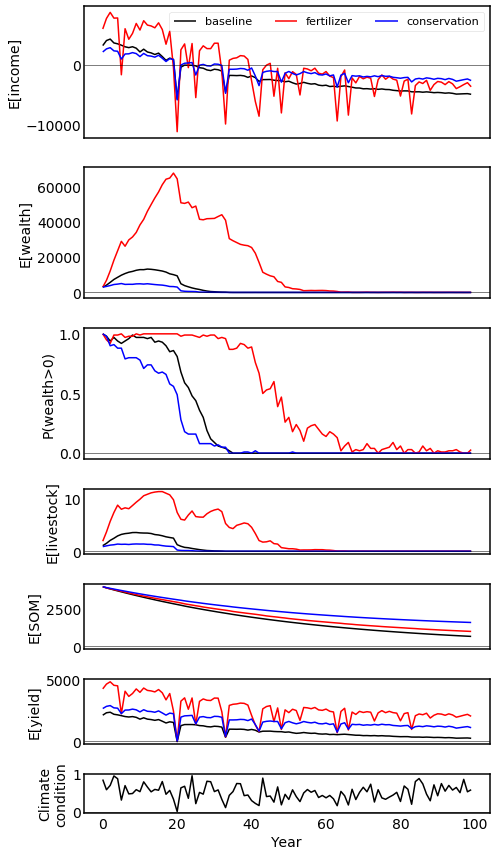

In [4]:
fig, axs = plt.subplots(7,1,figsize=(7,12), 
                        gridspec_kw={'height_ratios':[1,1,1,0.5,0.5,0.5,0.3]}, sharex=True)
names = ['E[income]', 'E[wealth]','P(wealth>0)','E[livestock]',
         'E[SOM]','E[yield]','Climate\ncondition']
for m, mod in mods.items():
    objs = [mod.agents.income, mod.agents.wealth[:-1], mod.agents.wealth[:-1]>0, 
            mod.agents.livestock[:-1], mod.land.organic[:-1], mod.land.yields['subs']]
    xs = np.arange(mod.T)
    for o, obj in enumerate(objs):
        axs[o].plot(xs, np.mean(obj,axis=1), label=m, color=cols[m], lw=1.5, ls='-')
        
axs[-1].plot(xs, mod.climate.rain, color='k', lw=1.5)

for a, ax in enumerate(axs):
    ax.grid(False)
    ax.set_ylabel(names[a])
    ax.axhline(0, color='k', lw=0.5, label='_nolegend_')
axs[0].legend(ncol=3)
axs[-1].set_xlabel('Year')

### (b) Path dependence (multi scenario, single agent)

Text(0.5, 0, 'Year')

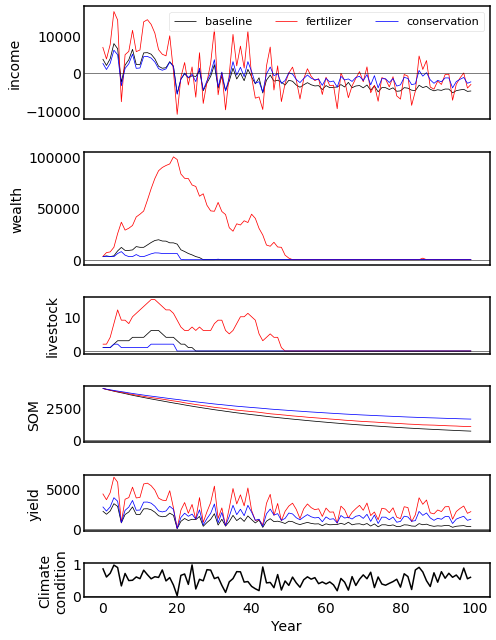

In [5]:
fig, axs = plt.subplots(6,1,figsize=(7,9), 
                        gridspec_kw={'height_ratios':[1,1,0.5,0.5,0.5,0.3]}, sharex=True)
names = ['income','wealth','livestock','SOM','yield','Climate\ncondition']
for m, mod in mods.items():
    objs = [mod.agents.income, mod.agents.wealth[:-1], mod.agents.livestock[:-1],
            mod.land.organic[:-1], mod.land.yields['subs']]
    xs = np.arange(mod.T)
    for o, obj in enumerate(objs):
        axs[o].plot(xs, obj[:,0], lw=.75, ls='-', label=m, color=cols[m])
        
axs[-1].plot(xs, mod.climate.rain, color='k', lw=1.5)

for a, ax in enumerate(axs):
    ax.grid(False)
    ax.set_ylabel(names[a])
    ax.axhline(0, color='k', lw=0.5, label='_nolegend_')
axs[0].legend(ncol=3)
axs[-1].set_xlabel('Year')

### (c) Path dependence (single scenario, identical agents)

Text(0.5, 0, 'Year')

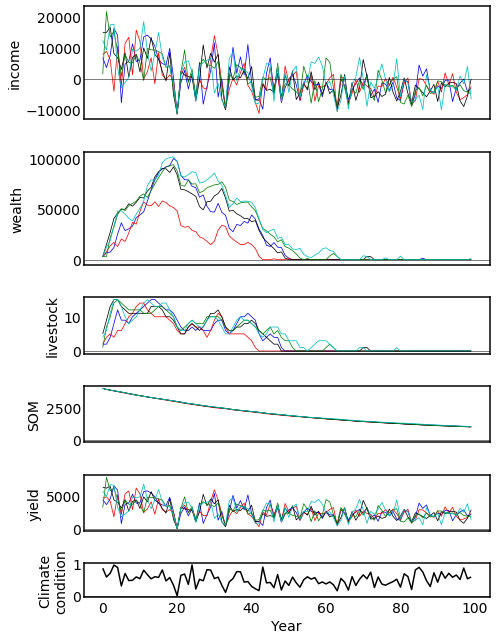

In [6]:
mod = mods['fertilizer']
nplot = 5
fig, axs = plt.subplots(6,1,figsize=(7,9), 
                        gridspec_kw={'height_ratios':[1,1,0.5,0.5,0.5,0.3]}, sharex=True)
names = ['income','wealth','livestock','SOM','yield','Climate\ncondition']
objs = [mod.agents.income, mod.agents.wealth[:-1], mod.agents.livestock[:-1],
        mod.land.organic[:-1], mod.land.yields['subs']]
xs = np.arange(mod.T)
for o, obj in enumerate(objs):
    for a in range(nplot):
        axs[o].plot(xs, obj[:,a], lw=.75, ls='-')
        
axs[-1].plot(xs, mod.climate.rain, color='k', lw=1.5)

for a, ax in enumerate(axs):
    ax.grid(False)
    ax.set_ylabel(names[a])
    ax.axhline(0, color='k', lw=0.5, label='_nolegend_')

axs[-1].set_xlabel('Year')

# 2. Utility maximization

### (a) beliefs

In [7]:
def plot_beliefs(m):
    blfs = m.agents.blf.quantities
    n_blf = len(blfs)
    fig, axs = plt.subplots(2, n_blf, figsize=(3*n_blf, 4), sharex=True, sharey='row')
    ax_flat = axs.flatten()


    for b, blf in enumerate(blfs):
        # mean values
        means = m.agents.blf.mu[blf]
        q_m = np.percentile(means, q=[5,25,50,75,95], axis=1)
        axs[0,b].fill_between(np.arange(m.T+1), q_m[0], q_m[-1], color='0.7')
        axs[0,b].fill_between(np.arange(m.T+1), q_m[1], q_m[-2], color='0.5')
        axs[0,b].plot(q_m[2], color='k', lw=2)

        # variances
        sdz = np.sqrt(m.agents.blf.var[blf])
        s_m = np.percentile(sdz, q=[5,25,50,75,95], axis=1)
        axs[1,b].fill_between(np.arange(m.T+1), s_m[0], s_m[-1], color='0.7')
        axs[1,b].fill_between(np.arange(m.T+1), s_m[1], s_m[-2], color='0.5')
        axs[1,b].plot(s_m[2], color='k', lw=2)

        axs[0,b].set_title(blf)

    for a, ax in enumerate(ax_flat):
        ax.grid(False)
        ax.axhline(0, color='k', lw=0.7)
    for a, ax in enumerate(axs[1]):
        ax.set_xlabel('year')
    axs[0,0].set_ylabel('Expected value')
    axs[1,0].set_ylabel('Std. deviation')

### (b) utility throughout time

In [8]:
def plot_utility(m):
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    ag_i = 0
    colors = ['k','r','b','y']
    names = ['baseline','fertilizer','conservation','both']
    xs = np.arange(m.T)
    for o, opt in enumerate(m.agents.decision_options):
        ax.plot(xs, m.agents.exp_util[:,o,ag_i], label=names[o], color=colors[o])
        # add in times of infeasibility
        feas_o = m.agents.option_feasibility[:,o,ag_i]
        ax.scatter(xs[~feas_o], m.agents.exp_util[~feas_o,o,ag_i], color=colors[o])

    ax.legend(loc=3)
    ax.grid(False)
    ax.set_xlabel('Year')
    ax.set_ylabel('Expected utility')
    ax.text(0.98,0.98,'Note: points denote when an option is unaffordable', 
            ha='right',va='top', transform=ax.transAxes)

### (c) decisions over time

In [9]:
def plot_decisions(m):
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    cum_fert = np.cumsum(m.agents.choices['fertilizer'][:,0])
    cum_cons = np.cumsum(m.agents.choices['conservation'][:,0])
    xs = np.arange(m.T)+1
    ax.plot(xs, cum_fert, 'o-', label='fertilizer', color='red')
    ax.plot(xs, cum_cons, 'o-', label='conservation', color='blue')
    ax.plot([0,m.T+1], [0,m.T+1], color='k', lw=0.5, label='_nolegend_')
    ax.axhline(0,color='k',lw=0.5)
    ax.axvline(0,color='k',lw=0.5)
    ax.grid(False)
    ax.set_xlabel('Year')
    ax.set_ylabel('Cumulative uses of option')
    ax.legend()

## EXPERIMENTS

#### (A: LOW RISK TOLERANCE)

In [10]:
imp.reload(mod_code)
imp.reload(base_inputs)
inputs = base_inputs.compile()

inputs['model']['T'] = 30
inputs['model']['n_agents'] = 100
inputs['model']['seed'] = 0
inputs['decisions']['framework'] = 'util_max'

inputs['agents']['land_area_init'] = [2]
inputs['decisions']['risk_tolerance_params'] = [1000,0]
inputs['market']['fertilizer_cost'] = 30
# inputs['adaptation']['conservation']['organic_N_added'] = 80
# inputs['adaptation']['fertilizer']['application_rate'] = 80
# inputs['livestock']['frac_N_import'] = 0

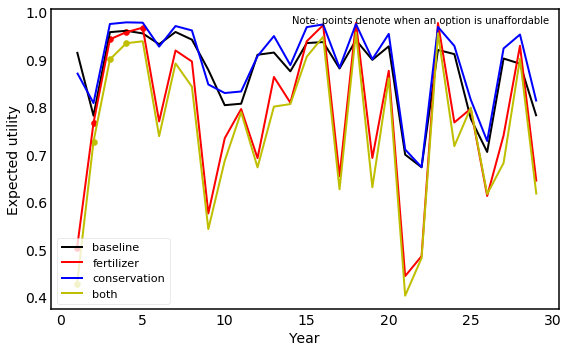

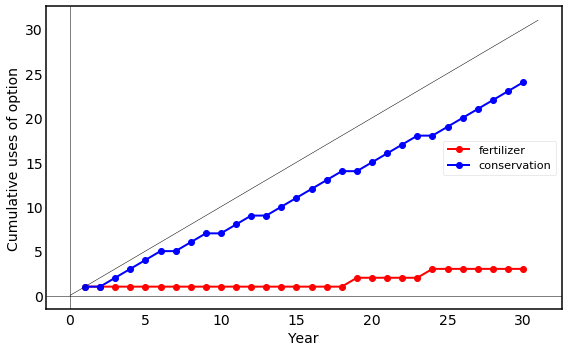

In [11]:
#### RUN THE MODEL ####
mod = mod_code.Model(inputs)
for t in range(mod.T):
    mod.step()
# plot_beliefs(mod)
plot_utility(mod)
plot_decisions(mod)

--> don't choose fertilizer often

#### (B: HIGH RISK TOLERANCE)

In [12]:
imp.reload(mod_code)
imp.reload(base_inputs)
inputs = base_inputs.compile()

inputs['model']['T'] = 30
inputs['model']['n_agents'] = 100
inputs['model']['seed'] = 0
inputs['decisions']['framework'] = 'util_max'

inputs['agents']['land_area_init'] = [2]
inputs['decisions']['risk_tolerance_params'] = [10000,0]
inputs['market']['fertilizer_cost'] = 30
# inputs['adaptation']['conservation']['organic_N_added'] = 80
# inputs['adaptation']['fertilizer']['application_rate'] = 80
# inputs['livestock']['frac_N_import'] = 0

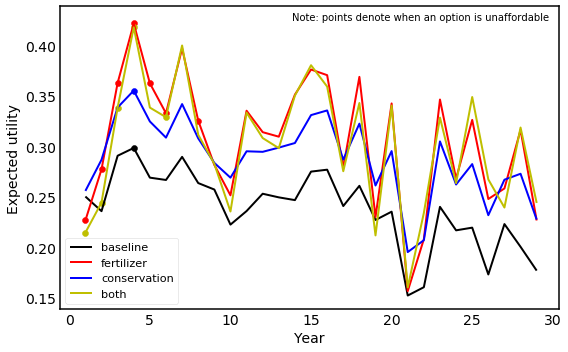

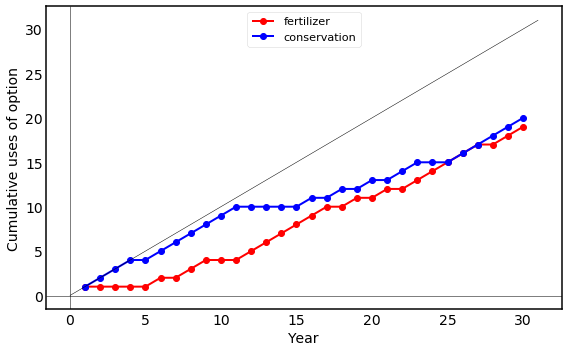

In [13]:
#### RUN THE MODEL ####
mod = mod_code.Model(inputs)
for t in range(mod.T):
    mod.step()
# plot_beliefs(mod)
plot_utility(mod)
plot_decisions(mod)

--> fertilizer chosen more